# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{n} \sum\limits_{i=1}^n \frac{1}{2} x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [1]:
from scipy.stats import ortho_group
import numpy as np
def get_matrix_2(d,mu,L):
    vec=np.random.uniform(low=mu, high=L, size=d-2)
    vec=np.append(vec,mu)
    vec=np.append(vec,L)
    O=ortho_group.rvs(dim=d)
    D=np.diag(vec)
    temp=np.matmul(np.transpose(O),D)
    result = np.matmul(temp,O)
    return result

In [2]:
L=1000
DIMENSIONS=100
mu=1
L=1000

import numpy as np
def f(A,b,x):
    return 1/2*np.matmul(np.matmul(x.T,A),x)-np.matmul(b.T,x)
def grad_f(A,b,x):
    return np.matmul(A,x)-b.T

functions=[]
grad_functions=[]

data=[]
for i in range(10):
    data.append([get_matrix_2(DIMENSIONS,mu,L),np.random.rand(DIMENSIONS)])

for i in range(10):
    functions.append(lambda x : f(data[i][0],data[i][1],x))
    grad_functions.append(lambda x : grad_f(data[i][0],data[i][1],x))
    


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def Rand(x,n_percent):
    coordinates=np.random.randint(0,100,n_percent)
    result=np.zeros(len(x))
    for coord in coordinates:
        result[coord]=x[coord]
    information=n_percent
    return result,information

def rand1(x):
    return Rand(x,1)
def rand5(x):
    return Rand(x,5)
def rand10(x):
    return Rand(x,10)
def rand20(x):
    return Rand(x,20)

def top10(x): #Пересылает 10 наибольших по модулю координат
    abs_arr = np.abs(x)
    sorted_indices = np.argsort(abs_arr)
    top_indices = sorted_indices[-10:]
    
    result=np.zeros(len(x))
    for index in top_indices:
        result[index]=x[index]
    information=10
    return result,information
    
    
def client_work(x,client_number,compr_oper): 
    gradient=grad_functions[client_number](x)
    return compr_oper(gradient)

def sim_comp_GD(x_start,step,iterations,n,compr_oper):
    information=np.zeros(iterations) #Число координат переданных от устройства к серверу
    gradients=np.zeros(iterations)
    x=x_start
    inf=0 #Счетчик инфомрации для итераций
    for i in range(iterations):
        server_gradient=np.zeros(len(x_start))
        for client_number in range(n):
            client_gradient,client_inf =client_work(x,client_number,compr_oper) #С каждого из n клиентов собираем градиент и число информации
            server_gradient+=client_gradient
            inf+=client_inf #Добавляем информацию от клиента в общий банк

        information[i]=inf
        gradients[i]=np.linalg.norm(server_gradient)**2
        
        x=x-step*server_gradient/n
    return x,gradients,information

# Шаги

В каждом эксперименте подобран максимальный шаг при котором метод сходится

## Шаги для Rand1

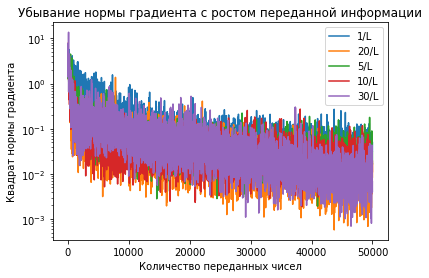

In [5]:
results_rand1_1=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=1/L,iterations=5000,n=10,compr_oper=rand1)
results_rand1_2=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=20/L,iterations=5000,n=10,compr_oper=rand1)
results_rand1_3=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=5/L,iterations=5000,n=10,compr_oper=rand1)
results_rand1_4=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=10/L,iterations=5000,n=10,compr_oper=rand1)
results_rand1_5=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=30/L,iterations=5000,n=10,compr_oper=rand1)

plt.plot(results_rand1_1[2],results_rand1_1[1],label='1/L')
plt.plot(results_rand1_2[2],results_rand1_2[1],label='20/L')
plt.plot(results_rand1_3[2],results_rand1_3[1],label='5/L')
plt.plot(results_rand1_4[2],results_rand1_4[1],label='10/L')
plt.plot(results_rand1_5[2],results_rand1_5[1],label='30/L')
plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

__Вывод :__ чаще всего 20, 30

## Шаги для Rand5

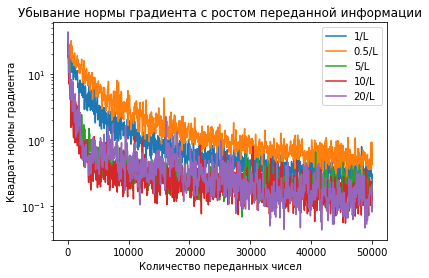

In [6]:
results_rand5_1=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=1/L,iterations=1000,n=10,compr_oper=rand5)
results_rand5_2=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=0.5/L,iterations=1000,n=10,compr_oper=rand5)
results_rand5_3=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=5/L,iterations=1000,n=10,compr_oper=rand5)
results_rand5_4=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=10/L,iterations=1000,n=10,compr_oper=rand5)
results_rand5_5=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=20/L,iterations=1000,n=10,compr_oper=rand5)
#results_rand5_6=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=30/L,iterations=1000,n=10,compr_oper=rand5)
#results_rand5_7=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=40/L,iterations=1000,n=10,compr_oper=rand5)

plt.plot(results_rand5_1[2],results_rand5_1[1],label='1/L')
plt.plot(results_rand5_2[2],results_rand5_2[1],label='0.5/L')
plt.plot(results_rand5_3[2],results_rand5_3[1],label='5/L')
plt.plot(results_rand5_4[2],results_rand5_4[1],label='10/L')
plt.plot(results_rand5_5[2],results_rand5_5[1],label='20/L')
#plt.plot(results_rand5_6[2],results_rand5_6[1],label='30/L')
#plt.plot(results_rand5_7[2],results_rand5_7[1],label='40/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

__Вывод:__ 10,20,5

### Шаги для Rand10

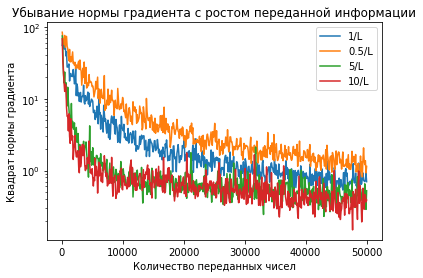

In [7]:
results_rand10_1=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=1/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_2=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=0.5/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_3=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=5/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_4=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=10/L,iterations=500,n=10,compr_oper=rand10)
#results_rand10_5=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=20/L,iterations=100,n=10,compr_oper=rand10)
#results_rand10_6=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=30/L,iterations=1000,n=10,compr_oper=rand5)
#results_rand10_7=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=40/L,iterations=1000,n=10,compr_oper=rand5)

plt.plot(results_rand10_1[2],results_rand10_1[1],label='1/L')
plt.plot(results_rand10_2[2],results_rand10_2[1],label='0.5/L')
plt.plot(results_rand10_3[2],results_rand10_3[1],label='5/L')
plt.plot(results_rand10_4[2],results_rand10_4[1],label='10/L')
#plt.plot(results_rand10_5[2],results_rand10_5[1],label='20/L')
#plt.plot(results_rand10_6[2],results_rand10_6[1],label='30/L')
#plt.plot(results_rand10_7[2],results_rand10_7[1],label='40/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

__Вывод:__ 10,5

### Шаги для Rand20

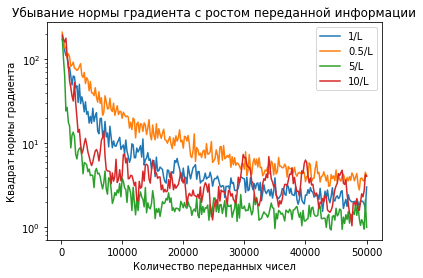

In [8]:
results_rand20_1=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=1/L,iterations=250,n=10,compr_oper=rand20)
results_rand20_2=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=0.5/L,iterations=250,n=10,compr_oper=rand20)
results_rand20_3=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=5/L,iterations=250,n=10,compr_oper=rand20)
results_rand20_4=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=10/L,iterations=250,n=10,compr_oper=rand20)
#results_rand20_5=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=20/L,iterations=50,n=10,compr_oper=rand20)
#results_rand10_6=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=30/L,iterations=1000,n=10,compr_oper=rand5)
#results_rand10_7=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=40/L,iterations=1000,n=10,compr_oper=rand5)

plt.plot(results_rand20_1[2],results_rand20_1[1],label='1/L')
plt.plot(results_rand20_2[2],results_rand20_2[1],label='0.5/L')
plt.plot(results_rand20_3[2],results_rand20_3[1],label='5/L')
plt.plot(results_rand20_4[2],results_rand20_4[1],label='10/L')
#plt.plot(results_rand20_5[2],results_rand20_5[1],label='20/L')
#plt.plot(results_rand10_6[2],results_rand10_6[1],label='30/L')
#plt.plot(results_rand10_7[2],results_rand10_7[1],label='40/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

__Вывод:__ 5,10

# Сравнение всех операторов

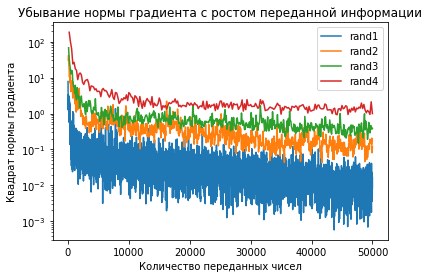

In [9]:
plt.plot(results_rand1_2[2],results_rand1_2[1],label='rand1')
plt.plot(results_rand5_5[2],results_rand5_5[1],label='rand2')
plt.plot(results_rand10_4[2],results_rand10_4[1],label='rand3')
plt.plot(results_rand20_3[2],results_rand20_3[1],label='rand4')
plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

__Вывод:__ rand1

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

## Обычный спуск с сжатием

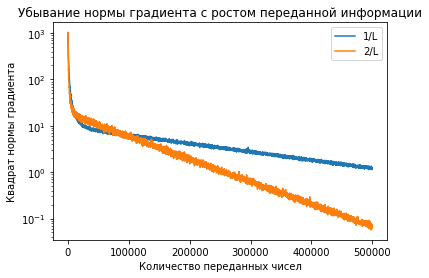

In [10]:
results_normal_top10_1=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=1/L,iterations=5000,n=10,compr_oper=top10)
results_normal_top10_2=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=2/L,iterations=5000,n=10,compr_oper=top10)
#results_normal_top10_3=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=5/L,iterations=5000,n=10,compr_oper=top10)
#results_normal_top10_4=sim_comp_GD(x_start=np.zeros(DIMENSIONS),step=10/L,iterations=5000,n=10,compr_oper=top10)

plt.plot(results_normal_top10_1[2],results_normal_top10_1[1],label='1/L')
plt.plot(results_normal_top10_2[2],results_normal_top10_2[1],label='2/L')
#plt.plot(results_normal_top10_3[2],results_normal_top10_3[1],label='5/L')
#plt.plot(results_normal_top10_4[2],results_normal_top10_4[1],label='10/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

При росте шага алгоритм быстро перестает сходиться : если взять шаг $5/L$, то сходимости не увидим

## Error_feedback

In [11]:
def client_work_error_feedback(x,compr_oper,client_number,step,e): 
    client_gradient=grad_functions[client_number](x)
    result,information=compr_oper(e[client_number]+step*client_gradient)
    e[client_number]=e[client_number]+step*client_gradient-result
    return result,information,e

def sim_comp_GD_error_feedback(x_start,step,iterations,n,compr_oper):
    e=np.zeros((10,DIMENSIONS))
    information=np.zeros(iterations) #Число координат переданных от устройства к серверу
    gradients=np.zeros(iterations)
    x=x_start
    inf=0 #Счетчик инфомрации для итераций
    for i in range(iterations):
        server_gradient=np.zeros(len(x_start))
        for client_number in range(n):
            client_gradient,client_inf,e = client_work_error_feedback(x,compr_oper,client_number,step,e) #С каждого из n клиентов собираем градиент и число информации
            server_gradient+=client_gradient
            inf+=client_inf #Добавляем информацию от клиента в общий банк

        information[i]=inf
        gradients[i]=np.linalg.norm(server_gradient)**2
        
        x=x-step*server_gradient/n
    return x,gradients,information

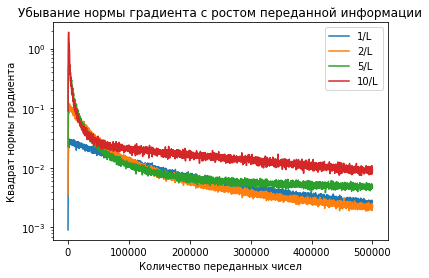

In [12]:
results_top10_1=sim_comp_GD_error_feedback(x_start=np.zeros(DIMENSIONS),step=1/L,iterations=5000,n=10,compr_oper=top10)
results_top10_2=sim_comp_GD_error_feedback(x_start=np.zeros(DIMENSIONS),step=2/L,iterations=5000,n=10,compr_oper=top10)
results_top10_3=sim_comp_GD_error_feedback(x_start=np.zeros(DIMENSIONS),step=5/L,iterations=5000,n=10,compr_oper=top10)
results_top10_4=sim_comp_GD_error_feedback(x_start=np.zeros(DIMENSIONS),step=10/L,iterations=5000,n=10,compr_oper=top10)

plt.plot(results_top10_1[2],results_top10_1[1],label='1/L')
plt.plot(results_top10_2[2],results_top10_2[1],label='2/L')
plt.plot(results_top10_3[2],results_top10_3[1],label='5/L')
plt.plot(results_top10_4[2],results_top10_4[1],label='10/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

## Сравнительный график

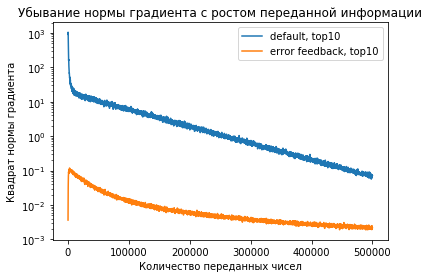

In [13]:
plt.plot(results_normal_top10_2[2],results_normal_top10_2[1],label='default, top10')
plt.plot(results_top10_2[2],results_top10_2[1],label='error feedback, top10')
plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

__Вывод__: без модификации алгоритм быстро перестает сходиться  
Как с модификацией так и без, наилучшая сходимость происходит при шаге порядка $2/L$
Судя по графику, error feedback сходится быстрее

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

#### $$\nabla f = \nabla_x \left(\frac{1}{n}\sum\limits_{i=1}^n \ln(1+e^{-y_ix^TA_i})+\lambda ||x||^2\right)=-\frac{1}{n}\sum\limits_{i=1}^n\sigma(-y_ix^TA_i)A_iy_i+2\lambda x$$

$$L \leq \frac{1}{4n}\sum\limits_{i=1}^nx_ix_i^T$$

In [14]:
#Импортируем данные
from sklearn.datasets import load_svmlight_file
import numpy as np
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape
y=y-1.5
y=2*y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.2,test_size=0.8, random_state=41)

In [16]:
#Задаем функции для логлосса

def sigma(x):
    return 1/(1+np.exp(-x))

class log_function:
    def __init__(self,A,y,L):
        self.A=A
        self.y=y
        self.L=L
        
    def get_grad(self, x):
        summ=0
        A=self.A
        y=self.y
        L=self.L
        for i in range(np.shape(A)[0]):
            summ+=sigma(-y[i]*np.matmul(x.T,A[i]))*A[i]*y[i]
        return -summ/np.shape(A)[0]+x*L/500
    
    def get_L(self):
        return self.L

In [17]:
#Создаем массив функций f_i
functions=[]
for i in range(10):
    A=X_train[162*i:162*(i+1)]
    y=y_train[162*i:162*(i+1)]
    functions.append(log_function(A,y,get_L(A)))

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от устройств к серверу

## Обычный распределенный спуск - реализация

In [34]:
def Rand(x,n_percent):
    coord_amount=int(n_percent*len(X_train[0])/100)
    coordinates=np.random.randint(0,len(X_train[0]),coord_amount)
    result=np.zeros(len(x))
    for coord in coordinates:
        result[coord]=x[coord]
    information=coord_amount
    return result,information

def rand10(x): 
    return Rand(x,10)

def top10(x): #Пересылает 10% наибольших по модулю координат
    abs_arr = np.abs(x)
    coord_amount=int(10*112/100)
    
    sorted_indices = np.argsort(abs_arr)
    top_indices = sorted_indices[-coord_amount:]
    
    result=np.zeros(len(x))
    for index in top_indices:
        result[index]=x[index]
    information=coord_amount
    return result,information
    
    
def client_work(x,client_number,compr_oper): 
    gradient=functions[client_number].get_grad(x)
    return compr_oper(gradient)

def sim_comp_GD(x_start,step,iterations,n,compr_oper):
    information=np.zeros(iterations) #Число координат переданных от устройства к серверу
    gradients=np.zeros(iterations)
    x=x_start
    xes=[x]
    inf=0 #Счетчик информации для итераций
    for i in range(iterations):
        server_gradient=np.zeros(len(x_start))
        for client_number in range(n):
            client_gradient,client_inf =client_work(x,client_number,compr_oper) #С каждого из n клиентов собираем градиент и число информации
            server_gradient+=client_gradient
            inf+=client_inf #Добавляем информацию от клиента в общий банк

        information[i]=inf
        gradients[i]=np.linalg.norm(server_gradient)**2
        
        x=x-step*server_gradient/n
        xes.append(x)
    return xes[1:],gradients,information

## Error feedback - реализация

In [35]:
def client_work_error_feedback(x,compr_oper,client_number,step,e): 
    client_gradient=functions[client_number].get_grad(x)
    result,information=compr_oper(e[client_number]+step*client_gradient)
    e[client_number]=e[client_number]+step*client_gradient-result
    return result,information,e

def sim_comp_GD_error_feedback(x_start,step,iterations,n,compr_oper):
    e=np.zeros((10,len(X_train[0])))
    information=np.zeros(iterations) #Число координат переданных от устройства к серверу
    gradients=np.zeros(iterations)
    x=x_start
    xes=[x]
    inf=0 #Счетчик инфомрации для итераций
    for i in range(iterations):
        server_gradient=np.zeros(len(x_start))
        for client_number in range(n):
            client_gradient,client_inf,e = client_work_error_feedback(x,compr_oper,client_number,step,e) #С каждого из n клиентов собираем градиент и число информации
            server_gradient+=client_gradient
            inf+=client_inf #Добавляем информацию от клиента в общий банк

        information[i]=inf
        gradients[i]=np.linalg.norm(server_gradient)**2
        
        x=x-step*server_gradient/n
        xes.append(x)
    return xes[1:],gradients,information

## Diana - реализация

In [36]:
def client_work_DIANA(x,compr_oper,client_number,step,h):
    client_gradient=functions[client_number].get_grad(x)
    delta_ik=client_gradient-h[client_number]
    result,information=compr_oper(delta_ik)
    return delta_ik,information

def sim_comp_GD_DIANA(x_start,step,iterations,n,compr_oper,alpha=1):
    #Задаем начальные значения для h
    h=[]
    for i in range(n):
        h.append(functions[i].get_grad(x_start))

    information=np.zeros(iterations) #Число координат переданных от устройства к серверу
    gradients=np.zeros(iterations)
    x=x_start
    xes=[x]
    inf=0 #Счетчик инфомрации для итераций
    for i in range(iterations):
        server_gradient=np.zeros(len(x_start))
        for client_number in range(n):
            delta,info=client_work_DIANA(x,compr_oper,client_number,step,h) #С каждого из n клиентов собираем градиент и число информации
            inf+=info #Добавляем информацию от клиента в общий банк
            server_gradient+=h[client_number]+delta # Добавляем в клад в общий градиент от клиента
            h[client_number]+=alpha*delta #Корректируем поправку
        
        information[i]=inf
        gradients[i]=np.linalg.norm(server_gradient)**2
        x=x-step*server_gradient/n
        xes.append(x)
    return xes[1:],gradients,information

 # __(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [37]:
#Оцениваем L для всех функций
L=0
for func in functions:
    if (func.get_L()>L):
        L=func.get_L()
L

3.4025760646471275

# Rand 10 - исследование шага

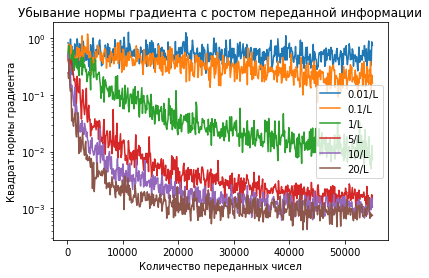

In [38]:
results_rand10_00=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=0.01/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_01=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=0.1/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_1=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=1/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_2=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=5/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_3=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=10/L,iterations=500,n=10,compr_oper=rand10)
results_rand10_4=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=20/L,iterations=500,n=10,compr_oper=rand10)

plt.plot(results_rand10_00[2],results_rand10_00[1],label='0.01/L')
plt.plot(results_rand10_01[2],results_rand10_01[1],label='0.1/L')
plt.plot(results_rand10_1[2],results_rand10_1[1],label='1/L')
plt.plot(results_rand10_2[2],results_rand10_2[1],label='5/L')
plt.plot(results_rand10_3[2],results_rand10_3[1],label='10/L')
plt.plot(results_rand10_4[2],results_rand10_4[1],label='20/L')
plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

# Top 10 - исследование шага

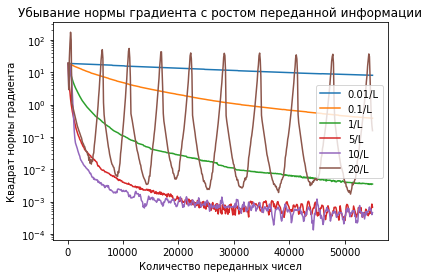

In [39]:
results_top10_00=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=0.01/L,iterations=500,n=10,compr_oper=top10)
results_top10_01=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=0.1/L,iterations=500,n=10,compr_oper=top10)
results_top10_1=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=1/L,iterations=500,n=10,compr_oper=top10)
results_top10_2=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=5/L,iterations=500,n=10,compr_oper=top10)
results_top10_3=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=10/L,iterations=500,n=10,compr_oper=top10)
results_top10_4=sim_comp_GD(x_start=np.zeros(len(X_train[0])),step=20/L,iterations=500,n=10,compr_oper=top10)


plt.plot(results_top10_00[2],results_top10_00[1],label='0.01/L')
plt.plot(results_top10_01[2],results_top10_01[1],label='0.1/L')
plt.plot(results_top10_1[2],results_top10_1[1],label='1/L')
plt.plot(results_top10_2[2],results_top10_2[1],label='5/L')
plt.plot(results_top10_3[2],results_top10_3[1],label='10/L')
plt.plot(results_top10_4[2],results_top10_4[1],label='20/L')
plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

# Rand 10(error feedback) - исследование шага

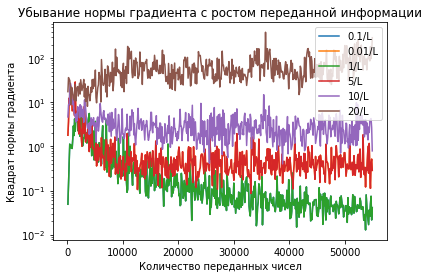

In [40]:
results_rand10er_00=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=0.01/L,iterations=500,n=10,compr_oper=rand10)
results_rand10er_01=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=0.1/L,iterations=500,n=10,compr_oper=rand10)
results_rand10er_1=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=1/L,iterations=500,n=10,compr_oper=rand10)
results_rand10er_2=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=5/L,iterations=500,n=10,compr_oper=rand10)
results_rand10er_3=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=10/L,iterations=500,n=10,compr_oper=rand10)
results_rand10er_4=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=20/L,iterations=500,n=10,compr_oper=rand10)

plt.plot(results_rand10er_00[2],results_rand10er_1[1],label='0.1/L')
plt.plot(results_rand10er_01[2],results_rand10er_2[1],label='0.01/L')
plt.plot(results_rand10er_1[2],results_rand10er_1[1],label='1/L')
plt.plot(results_rand10er_2[2],results_rand10er_2[1],label='5/L')
plt.plot(results_rand10er_3[2],results_rand10er_3[1],label='10/L')
plt.plot(results_rand10er_4[2],results_rand10er_4[1],label='20/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()

# Top 10(error feedback) - исследование шага

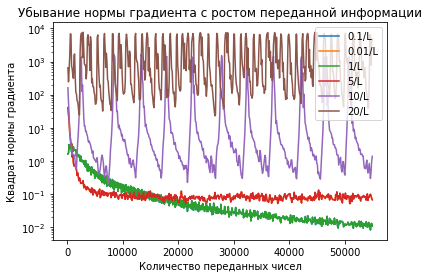

In [41]:
results_top10er_00=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=0.01/L,iterations=500,n=10,compr_oper=top10)
results_top10er_01=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=0.1/L,iterations=500,n=10,compr_oper=top10)
results_top10er_1=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=1/L,iterations=500,n=10,compr_oper=top10)
results_top10er_2=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=5/L,iterations=500,n=10,compr_oper=top10)
results_top10er_3=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=10/L,iterations=500,n=10,compr_oper=top10)
results_top10er_4=sim_comp_GD_error_feedback(x_start=np.zeros(len(X_train[0])),step=20/L,iterations=500,n=10,compr_oper=top10)

plt.plot(results_top10er_00[2],results_top10er_1[1],label='0.1/L')
plt.plot(results_top10er_01[2],results_top10er_2[1],label='0.01/L')
plt.plot(results_top10er_1[2],results_top10er_1[1],label='1/L')
plt.plot(results_top10er_2[2],results_top10er_2[1],label='5/L')
plt.plot(results_top10er_3[2],results_top10er_3[1],label='10/L')
plt.plot(results_top10er_4[2],results_top10er_4[1],label='20/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()


# Rand 10(DIANA) - исследование шага

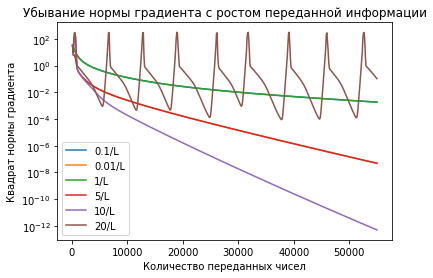

In [42]:
results_rand10DIANA_00=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=0.01/L,iterations=500,n=10,compr_oper=rand10)
results_rand10DIANA_01=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=0.1/L,iterations=500,n=10,compr_oper=rand10)
results_rand10DIANA_1=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=1/L,iterations=500,n=10,compr_oper=rand10)
results_rand10DIANA_2=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=5/L,iterations=500,n=10,compr_oper=rand10)
results_rand10DIANA_3=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=10/L,iterations=500,n=10,compr_oper=rand10)
results_rand10DIANA_4=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=20/L,iterations=500,n=10,compr_oper=rand10)

plt.plot(results_rand10DIANA_00[2],results_rand10DIANA_1[1],label='0.1/L')
plt.plot(results_rand10DIANA_01[2],results_rand10DIANA_2[1],label='0.01/L')
plt.plot(results_rand10DIANA_1[2],results_rand10DIANA_1[1],label='1/L')
plt.plot(results_rand10DIANA_2[2],results_rand10DIANA_2[1],label='5/L')
plt.plot(results_rand10DIANA_3[2],results_rand10DIANA_3[1],label='10/L')
plt.plot(results_rand10DIANA_4[2],results_rand10DIANA_4[1],label='20/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()


# Top 10(DIANA) - исследование шага

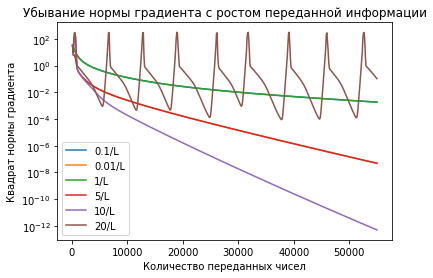

In [43]:
results_top10DIANA_00=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=0.01/L,iterations=500,n=10,compr_oper=top10)
results_top10DIANA_01=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=0.1/L,iterations=500,n=10,compr_oper=top10)
results_top10DIANA_1=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=1/L,iterations=500,n=10,compr_oper=top10)
results_top10DIANA_2=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=5/L,iterations=500,n=10,compr_oper=top10)
results_top10DIANA_3=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=10/L,iterations=500,n=10,compr_oper=top10)
results_top10DIANA_4=sim_comp_GD_DIANA(x_start=np.zeros(len(X_train[0])),step=20/L,iterations=500,n=10,compr_oper=top10)

plt.plot(results_top10DIANA_00[2],results_top10DIANA_1[1],label='0.1/L')
plt.plot(results_top10DIANA_01[2],results_top10DIANA_2[1],label='0.01/L')
plt.plot(results_top10DIANA_1[2],results_top10DIANA_1[1],label='1/L')
plt.plot(results_top10DIANA_2[2],results_top10DIANA_2[1],label='5/L')
plt.plot(results_top10DIANA_3[2],results_top10DIANA_3[1],label='10/L')
plt.plot(results_top10DIANA_4[2],results_top10DIANA_4[1],label='20/L')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Убывание нормы градиента с ростом переданной информации")
plt.legend()
plt.yscale('log')
plt.show()


# Итог

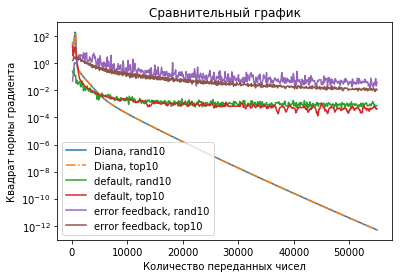

In [60]:
plt.plot(results_rand10DIANA_3[2],results_rand10DIANA_3[1],label='Diana, rand10',linestyle='-')
plt.plot(results_top10DIANA_3[2],results_top10DIANA_3[1],label='Diana, top10',linestyle='-.')
plt.plot(results_rand10_4[2],results_rand10_4[1],label='default, rand10')
plt.plot(results_top10_3[2],results_top10_3[1],label='default, top10')
plt.plot(results_rand10er_1[2],results_rand10er_1[1],label='error feedback, rand10')
plt.plot(results_top10er_1[2],results_top10er_1[1],label='error feedback, top10')

plt.xlabel("Количество переданных чисел")
plt.ylabel("Квадрат нормы градиента")
plt.title("Сравнительный график")
plt.legend()
plt.yscale('log')
plt.show()

__Вывод__ : Все спуски кроме Дианы в один момент начинают осциллировать в окрестности решения, Диана продолжает давить до конца. По идее error_feedback должен быть эффективнее чем обычный распределенный спуск, но в данном случае этого не наблюдается.

## Итоговый график с Accuracy

In [85]:
def get_accuracy(answer):
    y_pred=np.dot(answer,X_test.T)
    bool_arr = np.sign(y_pred) == np.sign(y_test) #Считаем ответ угаданным, если совпал знак
    result_arr = np.where(bool_arr, 1, 0)
    return np.sum(result_arr)/len(result_arr)

In [80]:
acc1=[]
acc2=[]
acc3=[]
acc4=[]
acc5=[]
acc6=[]
for i in range(0,len(results_rand10DIANA_3[2])):
    acc1.append(get_accuracy(results_rand10DIANA_3[0][i]))
for i in range(0,len(results_top10DIANA_3[2])):
    acc2.append(get_accuracy(results_top10DIANA_3[0][i]))
for i in range(0,len(results_rand10_4[2])):
    acc3.append(get_accuracy(results_rand10_4[0][i]))
for i in range(0,len(results_top10_3[2])):
    acc4.append(get_accuracy(results_top10_3[0][i]))
for i in range(0,len(results_rand10er_1[2])):
    acc5.append(get_accuracy(results_rand10er_1[0][i]))
for i in range(0,len(results_top10er_1[2])):
    acc6.append(get_accuracy(results_top10er_1[0][i]))

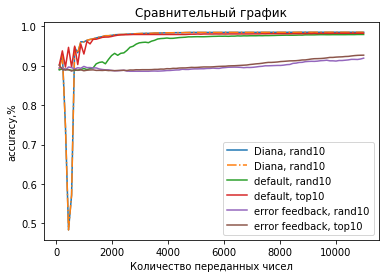

In [84]:
plt.plot(results_rand10DIANA_3[2][:100],acc1[:100],label='Diana, rand10',linestyle='-')
plt.plot(results_top10DIANA_3[2][:100],acc2[:100],label='Diana, rand10',linestyle='-.')
plt.plot(results_rand10_4[2][:100],acc3[:100],label='default, rand10')
plt.plot(results_top10_3[2][:100],acc4[:100],label='default, top10')
plt.plot(results_rand10er_1[2][:100],acc5[:100],label='error feedback, rand10')
plt.plot(results_top10er_1[2][:100],acc6[:100],label='error feedback, top10')

plt.xlabel("Количество переданных чисел")
plt.ylabel("accuracy,%")
plt.title("Сравнительный график")
plt.legend()
plt.show()

__Вывод__: в данном случае DIANA и обычный спуск с сжатием показывают себя хорошо, error_feedback как-то странно хромает